In [1]:
import tensorflow as tf

# GPU를 사용할 수 있는지 확인
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU를 사용할 수 있습니다.")
    # GPU 디바이스 정보 출력
    for gpu in gpu_available:
        print("GPU 디바이스:", gpu)
else:
    print("GPU를 사용할 수 없습니다.")

GPU를 사용할 수 있습니다.
GPU 디바이스: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, Activation, UpSampling1D, Add, LayerNormalization
from tensorflow.keras.layers import add, multiply, GlobalAveragePooling1D
from keras import  backend as K
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, sep='\s+')
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/Users/GACHON/Desktop/AiStudy/data/UCI HAR Dataset-20240320T080931Z-001/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/Users/GACHON/Desktop/AiStudy/data/UCI HAR Dataset-20240320T080931Z-001/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

    '''
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot
    '''

In [4]:
trainX, trainy, testX, testy = load_dataset()

(7352, 128, 9) (7352, 1) (2947, 128, 9) (2947, 1)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
# trainy에서 값이 0, 1, 2인 행의 인덱스 찾기
indices_to_remove = np.where((trainy == 0) | (trainy == 1) | (trainy == 2))[0]

# trainX와 trainy에서 해당 인덱스를 제거하여 새로운 trainX_filtered와 trainy_filtered 얻기
trainX_filtered = np.delete(trainX, indices_to_remove, axis=0)
trainy_filtered = np.delete(trainy, indices_to_remove, axis=0)

# trainX_filtered와 trainy_filtered의 shape 확인
print("Shape of trainX_filtered:", trainX_filtered.shape)
print("Shape of trainy_filtered:", trainy_filtered.shape)

Shape of trainX_filtered: (4067, 128, 9)
Shape of trainy_filtered: (4067, 1)


In [9]:
# trainy에서 값이 3인 것을 0으로, 값이 4인 것을 1로, 값이 5인 것을 2로 변경
trainy_filtered[trainy_filtered == 3] = 0
trainy_filtered[trainy_filtered == 4] = 1
trainy_filtered[trainy_filtered == 5] = 2

# 변경된 trainy_filtered의 값 확인
print("Modified trainy_filtered:\n", trainy_filtered)

Modified trainy_filtered:
 [[1]
 [1]
 [1]
 ...
 [2]
 [2]
 [2]]


In [10]:
# trainy에서 값이 0, 1, 2인 행의 인덱스 찾기
indices_to_remove = np.where((testy == 0) | (testy == 1) | (testy == 2))[0]

# trainX와 trainy에서 해당 인덱스를 제거하여 새로운 trainX_filtered와 trainy_filtered 얻기
testX_filtered = np.delete(testX, indices_to_remove, axis=0)
testy_filtered = np.delete(testy, indices_to_remove, axis=0)

# trainX_filtered와 trainy_filtered의 shape 확인
print("Shape of testX_filtered:", testX_filtered.shape)
print("Shape of testy_filtered:", testy_filtered.shape)

Shape of testX_filtered: (1560, 128, 9)
Shape of testy_filtered: (1560, 1)


In [11]:
# trainy에서 값이 3인 것을 0으로, 값이 4인 것을 1로, 값이 5인 것을 2로 변경
testy_filtered[testy_filtered == 3] = 0
testy_filtered[testy_filtered == 4] = 1
testy_filtered[testy_filtered == 5] = 2

# 변경된 trainy_filtered의 값 확인
print("Modified testy_filtered:\n", testy_filtered)

Modified testy_filtered:
 [[1]
 [1]
 [1]
 ...
 [2]
 [2]
 [2]]


In [12]:
trainy_one_hot = to_categorical(trainy_filtered)
testy_one_hot = to_categorical(testy_filtered)
print(trainy_filtered)
print(testy_filtered)

[[1]
 [1]
 [1]
 ...
 [2]
 [2]
 [2]]
[[1]
 [1]
 [1]
 ...
 [2]
 [2]
 [2]]


In [13]:
print("X train shape: ", trainX_filtered.shape)
print("Y train shape: ", trainy_filtered.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX_filtered.shape)
print("Y test shape: ", testy_filtered.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [14]:
print("0: Sitting:" ,np.where(trainy_filtered == 0)[0].size)
print("1: Standing:" ,np.where(trainy_filtered == 1)[0].size)
print("2: Laying:" ,np.where(trainy_filtered == 2)[0].size)

0: Sitting: 1286
1: Standing: 1374
2: Laying: 1407


In [15]:
unique, counts = np.unique(trainy_filtered, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy_filtered, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1286]
 [   1 1374]
 [   2 1407]]
Test data label statistics::
[[  0 491]
 [  1 532]
 [  2 537]]


In [16]:
X_train_all = trainX_filtered   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy_filtered

X_test_all = testX_filtered
y_test_all = testy_filtered

In [17]:
from sklearn.preprocessing import StandardScaler

def scale_data(trainX_filtered, testX_filtered):
 # remove overlap
 cut = int(trainX_filtered.shape[1] / 2)
 longX = trainX_filtered[:, -cut:, :]
 # flatten windows
 longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
 # flatten train and test
 flatTrainX = trainX_filtered.reshape((trainX_filtered.shape[0] * trainX_filtered.shape[1], trainX_filtered.shape[2]))
 flatTestX = testX_filtered.reshape((testX_filtered.shape[0] * testX_filtered.shape[1], testX_filtered.shape[2]))

 s = StandardScaler()
 # fit on training data
 s.fit(longX)
 # apply to training and test data
 longX = s.transform(longX)
 flatTrainX = s.transform(flatTrainX)
 flatTestX = s.transform(flatTestX)
 # reshape
 flatTrainX = flatTrainX.reshape((trainX_filtered.shape))
 flatTestX = flatTestX.reshape((testX_filtered.shape))
 return flatTrainX, flatTestX

In [18]:
trainX, testX = scale_data(trainX_filtered, testX_filtered)

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX_filtered, trainy_one_hot, trainy_filtered,test_size=0.3,random_state=100)

In [20]:
n_timesteps, n_features, n_outputs = trainX_filtered.shape[1], trainX_filtered.shape[2], trainy_one_hot.shape[1]

In [21]:
n_status = len(np.unique(y_train_one_hot))
n_status

2

In [22]:
idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train_one_hot = y_train_one_hot[idx]

In [23]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [24]:
def conv_block(in_x, nb_filter, kernel_size):

    x = Conv1D(nb_filter, kernel_size, padding='same')(in_x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [25]:
def convolutional_block(in_x, nb_filters, stride):

    F1, F2, F3 = nb_filters

    x = in_x

    x = Conv1D(F1, 3, strides=stride,  padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(F2, 3, strides=1, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(F3, 1, strides=1, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)

    x1 = Conv1D(F3, 1, strides=stride, padding='same', kernel_initializer="he_normal")(in_x)
    x1 = BatchNormalization()(x1)

    x = add([x, x1])
    x = Activation('relu')(x)

    return x

In [26]:
def attention_branch(in_x, nb_filter, kernel_size):

    x1 = conv_block(in_x, nb_filter, kernel_size)

    x = MaxPooling1D(2)(x1)
    x = conv_block(x, nb_filter, kernel_size)
    x = UpSampling1D(size = 2)(x)

    x2 = conv_block(x, nb_filter, kernel_size)

    if(K.int_shape(x1)!=K.int_shape(x2)):
        x2 = ZeroPadding1D(1)(x2)
        x2 = Cropping1D((1,0))(x2)

    x = add([x1, x2])

    x = conv_block(x, nb_filter, kernel_size)

    x = Conv1D(nb_filter, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)

    return x

In [27]:
def RTA_CNN():

    inputs = Input(shape=(n_timesteps,n_features))

    x = RTA_block(inputs, 16, 32)
    x = MaxPooling1D(4)(x)

    x = RTA_block(x, 32, 16)
    x = MaxPooling1D(4)(x)

    x = RTA_block(x, 64, 9)
    x = MaxPooling1D(2)(x)
    x = RTA_block(x, 64, 9)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.6)(x)

    x = RTA_block(x, 128, 3)
    x = MaxPooling1D(2)(x)
    x = RTA_block(x, 128, 3)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.6)(x)

    x = Flatten()(x)
    x = Dropout(0.7)(x)
    x = Dense(100,  activation='relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(n_outputs,  activation='softmax')(x)

    model = Model(inputs, x)

    return model

In [28]:
def se_block(in_x, nb_filter):
        squeeze = GlobalAveragePooling1D()(in_x)
        excitation = Dense(units=nb_filter // 2)(squeeze)
        excitation = Activation('relu')(excitation)
        excitation = Dense(units=nb_filter)(excitation)
        excitation = Activation('sigmoid')(excitation)
        excitation = Reshape((1,nb_filter))(excitation)
        scale = multiply([in_x,excitation])
        out = add([in_x, scale])

        return out

In [29]:
def SENET():

    inputs = Input(shape=(n_timesteps,n_features))

    x = Conv1D(16, 32, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 16)
    x = MaxPooling1D(4)(x)

    x = Conv1D(32, 16, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 32)
    x = MaxPooling1D(4)(x)

    x = Conv1D(64, 9, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 64)
    x = MaxPooling1D(2)(x)

    x = Conv1D(64, 9, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 64)
    x = MaxPooling1D(2)(x)

    x = Conv1D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 128)
    x = MaxPooling1D(2)(x)

    x = Conv1D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x, 128)
    x = MaxPooling1D(1)(x)

    x = Flatten()(x)
    x = Dense(300,  activation='relu')(x)
    x = Dense(n_outputs,  activation='softmax')(x)

    model = Model(inputs, x)
    '''
    return model
    '''
    return x

In [30]:
def RESNET50():

    inputs = Input(shape=(n_timesteps,n_features))

    filter_num = 64

    x = Conv1D(filter_num, 3, strides=2, kernel_initializer="he_normal")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling1D(3, stride=2)(x)

    x = convolutional_block(x, [filter_num, filter_num, filter_num * 4], 4)
    x = identity_block(x, [filter_num, filter_num, filter_num * 4])
    x = identity_block(x, [filter_num, filter_num, filter_num * 4])

    x = convolutional_block(x, [filter_num * 2, filter_num * 2, filter_num * 8], 4)
    x = identity_block(x, [filter_num * 2, filter_num * 2, filter_num * 8])
    x = identity_block(x, [filter_num * 2, filter_num * 2, filter_num * 8])
    x = identity_block(x, [filter_num * 2, filter_num * 2, filter_num * 8])

    x = convolutional_block(x, [filter_num * 4, filter_num * 4, filter_num * 16], 2)
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])
    x = identity_block(x, [filter_num * 4, filter_num * 4, filter_num * 16])

    x = convolutional_block(x, [filter_num * 8, filter_num * 8, filter_num * 32], 2)
    x = identity_block(x, [filter_num * 8, filter_num * 8, filter_num * 32])
    x = identity_block(x, [filter_num * 8, filter_num * 8, filter_num * 32])

    x = GlobalAveragePooling1D()(x)
    x = Dense(500, activation="relu", kernel_initializer="he_normal")(x)
    x = Dense(n_outputs, activation="softmax")(x)

    model = Model(inputs, x)

    return model

In [31]:
import math

def en_loss(y_true, y_pred):

    epsilon = 1.e-7
    gamma = float(0.3)

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    pos_pred = tf.pow(-tf.math.log(y_pred),gamma)
    nag_pred = tf.pow(-tf.math.log(1-y_pred),gamma)
    y_t = tf.multiply(y_true, pos_pred) + tf.multiply(1-y_true, nag_pred)
    en_loss = tf.reduce_mean(y_t)
    return en_loss

In [32]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=(n_timesteps, n_features))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    '''
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_outputs, activation="softmax")(x)
    return keras.Model(inputs, outputs)
    '''
    return x

In [52]:
from keras.models import Model
from keras.layers import Concatenate, Dense, Input

se_output =SENET()

# Transformer 모델 생성
input_shape = X_train.shape[1:]
trs_output = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.2,
)

# 두 출력을 연결합니다
concatenated_output = Concatenate()([se_output, trs_output])

# 새로운 Dense 레이어를 추가합니다
dense_layer = Dense(units=128, activation='relu')(concatenated_output)

# 출력 레이어를 추가합니다
outputs = Dense(units=n_outputs, activation='softmax')(dense_layer)

# 새로운 모델을 생성합니다
model = Model(inputs=[se_input, trs_input], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
model.summary()

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 128, 9), dtype=tf.float32, name='input_24'), name='input_24', description="created by layer 'input_24'") at layer "conv1d_88". The following previous layers were accessed without issue: []

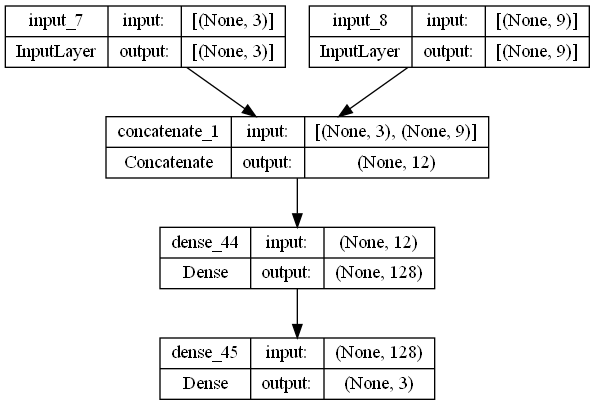

In [43]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [44]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(trainX_filtered, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,
                    validation_data = (X_val, y_val_one_hot), callbacks=[checkpoint_cb, early_stopping_cb], shuffle=True)

Epoch 1/20


ValueError: in user code:

    File "C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_3" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 128, 9) dtype=float32>]


In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

NameError: name 'history' is not defined

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

NameError: name 'history' is not defined

In [47]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX_filtered)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy_filtered,predy)
print(cm)
print(accuracy_score(testy_filtered,predy))
print(f1_score(testy_filtered,predy, average='weighted'))
print(classification_report(testy_filtered,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

ValueError: in user code:

    File "C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_3" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 128, 9) dtype=float32>]
